In [1]:
import torch

from packages import *

from BranchAndBound import BranchAndBound
import pandas as pd
from sklearn.decomposition import PCA, FastICA
import copy
import json
from Utilities.Timer import Timers
import warnings
from tqdm import tqdm
import matplotlib.patches as patches

from Utilities.Plotter import plotReachability
import sys


torch.set_printoptions(precision=8)
warnings.filterwarnings("ignore")

2023-06-26 13:16:02.457441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 13:16:02.534721: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-26 13:16:02.854383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-26 13:16:02.854414: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
from Bounding.LipschitzBound import LipschitzBounding

In [72]:
class NeuralNetwork(nn.Module):
    def __init__(self, path, A=None, B=None, c=None, activation='softplus', loadOrGenerate=True, listLayers=None):
        super().__init__()
        self.activation = activation
        if activation == 'softplus':
            activationF = nn.Softplus()
        elif activation == 'sigmoid':
            activationF = nn.Sigmoid()
        elif activation == 'tanh':
            activationF = nn.Tanh()
        else:
            activationF = nn.ReLU()

        if loadOrGenerate:
            stateDictionary = torch.load(path, map_location=torch.device("cpu"))
            layers = []
            for keyEntry in stateDictionary:
                if "weight" in keyEntry:
                    layers.append(nn.Linear(stateDictionary[keyEntry].shape[1], stateDictionary[keyEntry].shape[0]))
                    layers.append(activationF)
            layers.pop()
            self.Linear = nn.Sequential(
                *layers
            )
            self.load_state_dict(stateDictionary)

        else:
            layers = []
            for i in range(len(listLayers)-1):
                layers.append(nn.Linear(listLayers[i], listLayers[i+1]))
                layers.append(activationF,)
            layers.pop()

            self.Linear = nn.Sequential(*layers)
            # torch.nn.init.xavier_uniform_(self.Linear.weight)
        
        self.rotation = nn.Identity()
        self.A = A
        self.B = B
        self.c = c
        if self.A is None:
            dimInp = self.Linear[0].weight.shape[1]
            dimOut = self.Linear[-1].weight.shape[0]
            self.A = torch.zeros((dimInp, dimInp)).float()
            self.B = torch.eye(dimInp, dimOut).float()
            self.c = torch.zeros(dimOut).float()
        self.repetition = 1

    def load(self, path):
        stateDict = torch.load(path, map_location=torch.device("cpu"))
        self.load_state_dict(stateDict)

    def setRepetition(self, repetition):
        self.repetition = repetition

    def forward(self, x):
        x = self.rotation(x)
        for i in range(self.repetition):
            x = x @ self.A.T + self.Linear(x) @ self.B.T + self.c
        return x

In [94]:
def compareSecondOrderMethods(pcaDirections, config, device, network,
                                originalNetwork, horizonForLipschitz, lowerCoordinate, upperCoordinate,
                                boundingMethod):
    
    virtualBranching = config['virtualBranching']
    numberOfVirtualBranches = config['numberOfVirtualBranches']
    maxSearchDepthLipschitzBound = config['maxSearchDepthLipschitzBound']
    normToUseLipschitz = config['normToUseLipschitz']
    useTwoNormDilation = config['useTwoNormDilation']
    useSdpForLipschitzCalculation = config['useSdpForLipschitzCalculation']
    lipschitzSdpSolverVerbose = config['lipschitzSdpSolverVerbose']

    timers = Timers(["lowerBound",
                        "lowerBound:lipschitzForwardPass", "lowerBound:lipschitzCalc",
                        "lowerBound:lipschitzSearch",
                        "lowerBound:virtualBranchPreparation", "lowerBound:virtualBranchMin",
                        "upperBound",
                        "bestBound",
                        "branch", "branch:prune", "branch:maxFind", "branch:nodeCreation",
                        "LipSDP",
                        ])


        
    lowerBoundClass = LipschitzBounding(network, device, virtualBranching, maxSearchDepthLipschitzBound,
                                                 normToUseLipschitz, useTwoNormDilation, useSdpForLipschitzCalculation,
                                                 numberOfVirtualBranches, lipschitzSdpSolverVerbose,
                                                 [],
                                                 originalNetwork=originalNetwork,
                                                 horizon=horizonForLipschitz,
                                                 boundingMethod=boundingMethod
                                                 )
    
    M1, M2, = lowerBoundClass.compareSecondOrder(lowerCoordinate.reshape(1, -1), upperCoordinate.reshape(1, -1), pcaDirections[0], timers)
    
    return M1, M2, timers.timers


def main(Method = None):
    configFolder = "Config/"
    fileName = ["RobotArmS", "DoubleIntegratorS", "quadrotorS", "MnistS" , "test"]
    fileName = fileName[2]

    configFileToLoad = configFolder + fileName + ".json"

    with open(configFileToLoad, 'r') as file:
        config = json.load(file)

    eps = config['eps']
    verboseMultiHorizon = config['verboseMultiHorizon']
    normToUseLipschitz = config['normToUseLipschitz']
    useSdpForLipschitzCalculation = config['useSdpForLipschitzCalculation']
    finalHorizon = 1
    performMultiStepSingleHorizon = config['performMultiStepSingleHorizon']
    plotProjectionsOfHigherDims = config['plotProjectionsOfHigherDims']
    onlyPcaDirections = config['onlyPcaDirections']
    pathToStateDictionary = config['pathToStateDictionary']
    fullLoop = config['fullLoop']
    try:
        initialZonotope = config['InitialZonotope']
    except:
        initialZonotope = False
    try:
        activation = config['activation']
    except:
        activation = 'relu'
    try:
        splittingMethod = config['splittingMethod']
    except:
        splittingMethod = 'length'

    if Method == None:
        boundingMethod = config['boundingMethod']
    else:
        boundingMethod = Method
    A = B = c = None
    try:
        lowerCoordinate = torch.Tensor(config['lowerCoordinate'])
        upperCoordinate = torch.Tensor(config['upperCoordinate'])
    except:
        pass


    if not verboseMultiHorizon:
        plotProjectionsOfHigherDims = False

    if finalHorizon > 1 and performMultiStepSingleHorizon and\
            (normToUseLipschitz != 2 or not useSdpForLipschitzCalculation):
        raise ValueError

    if torch.cuda.is_available():
        device = torch.device("cuda", 0)
    else:
        device = torch.device("cpu")

    if False:
        print(device)
        print(' ')
    
    lowerCoordinate = lowerCoordinate.to(device)
    upperCoordinate = upperCoordinate.to(device)

    listLayers = [[6, 32, 3],
                  [6, 32, 32, 3],
                  [6, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 3]]
    
    simpleHessianBoundLayer = []
    LipHessianBoundLayer = []
    for listLayer in listLayers:
        simpleHessianBound = []
        LipHessianBound = []
        sys.stdout.flush()
        for __ in tqdm(range(10)):
            network = NeuralNetwork(pathToStateDictionary, A, B, c, activation=activation, loadOrGenerate=False, listLayers=listLayer)
            # print(network)
            # @TODO: move this
            horizonForLipschitz = 1
            originalNetworkZonotope = None
            dimZ = lowerCoordinate.shape[0]
            dim = network.Linear[0].weight.shape[1]
            outputDim = network.Linear[-1].weight.shape[0]
            network.to(device)
            inputData = (upperCoordinate - lowerCoordinate) * torch.rand(10000, dimZ, device=device) \
                                                        + lowerCoordinate
            # startTime = time.time()
            # totalLipSDPTime = 0
            for iteration in range(finalHorizon):
                inputDataVariable = Variable(inputData, requires_grad=False)
                # @TODO: move this
                if iteration == 0:
                        networkZonotope = copy.deepcopy(network)
                else:
                        rotation =  networkZonotope.rotation
                        networkZonotope = copy.deepcopy(network)
                        networkZonotope.rotation = rotation

                originalNetworkZonotope = copy.deepcopy(networkZonotope)
                pcaDirections = torch.rand((1, dim))
                M1, M2, timers = compareSecondOrderMethods(pcaDirections, config, device, networkZonotope,
                                                    originalNetworkZonotope, horizonForLipschitz, lowerCoordinate, upperCoordinate,
                                                    boundingMethod)
                simpleHessianBound.append(M1)
                LipHessianBound.append(M2)
        
        simpleHessianBoundLayer.append(torch.Tensor(simpleHessianBound))
        LipHessianBoundLayer.append(torch.Tensor(LipHessianBound))
        # sys.stdout.flush()
        # print("Simple Hessian Bound: ", torch.mean(torch.Tensor(simpleHessianBound)))
        # print("Lipschitz Hessian Bound: ", torch.mean(torch.Tensor(LipHessianBound)))
        # print('---')
        # sys.stdout.flush()

    simpleHessianBoundLayer = torch.vstack(simpleHessianBoundLayer)
    LipHessianBoundLayer = torch.vstack(LipHessianBoundLayer)
    return simpleHessianBoundLayer, LipHessianBoundLayer
            # totalLipSDPTime += timers['LipSDP'].totalTime
    # return totalLipSDPTime

        

In [95]:
if __name__ == '__main__':
    for Method in ['secondOrder']:
        for i in range(1):
            simpleHessianBoundLayer, LipHessianBoundLayer = main(Method)
            sys.stdout.flush()
            print("Simple Hessian Bound: ", torch.mean(simpleHessianBoundLayer, dim=1))
            print("Lipschitz Hessian Bound: ", torch.mean(LipHessianBoundLayer, dim=1))
            sys.stdout.flush()



100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

Simple Hessian Bound:  tensor([ 0.45011649,  1.18656564,  3.40619707,  8.94984722, 21.67673492,
        77.13667297])
Lipschitz Hessian Bound:  tensor([ 0.45011649,  0.64312333,  1.94182563,  5.18797302, 12.75680828,
        45.87216949])


tensor([ 0.45011649,  1.18656564,  3.40619707,  8.94984722, 21.67673492,
        77.13667297]) tensor([ 0.45011649,  0.64312333,  1.94182563,  5.18797302, 12.75680828,
        45.87216949])


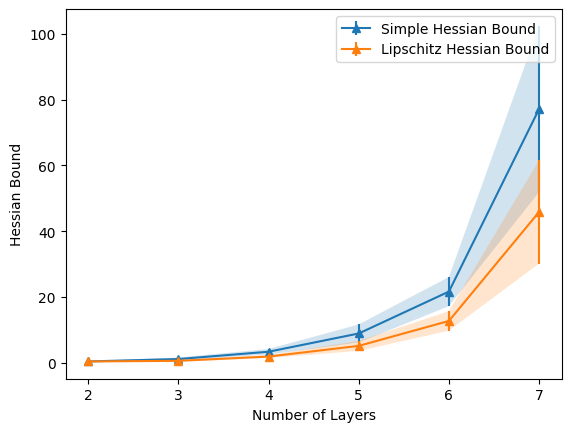

In [98]:
print(torch.mean(simpleHessianBoundLayer, dim=1), torch.mean(LipHessianBoundLayer, dim=1))

plt.errorbar([i + 2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) ,
              torch.std(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
# plt.plot([i for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
plt.fill_between([i+2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) - torch.std(simpleHessianBoundLayer, dim=1),
                torch.mean(simpleHessianBoundLayer, dim=1) + torch.std(simpleHessianBoundLayer, dim=1), alpha=0.2)

plt.errorbar([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) ,
                torch.std(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
# plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
plt.fill_between([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) - torch.std(LipHessianBoundLayer, dim=1),
                torch.mean(LipHessianBoundLayer, dim=1) + torch.std(LipHessianBoundLayer, dim=1), alpha=0.2)

# plt.yscale('log')
plt.ylabel('Hessian Bound')
plt.xlabel('Number of Layers')
plt.legend()
plt.show()